In [105]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [106]:
img = cv2.imread('./test_image/428340780_767510188614173_5890893365927811963_n.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)

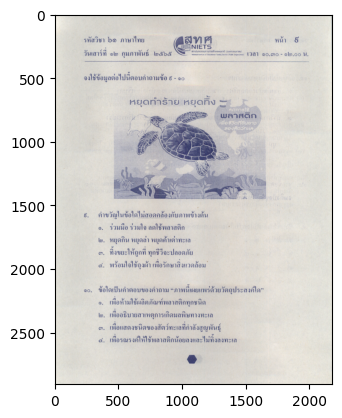

In [ ]:
img = cv2.medianBlur(img, 5)

plt.imshow(img)
plt.show()

[[228 224 213 ... 191 191 191]
 [232 229 214 ... 192 191 191]
 [233 230 218 ... 191 191 191]
 ...
 [205 235 235 ... 230 227 228]
 [204 233 235 ... 231 230 230]
 [203 232 235 ... 229 229 231]]


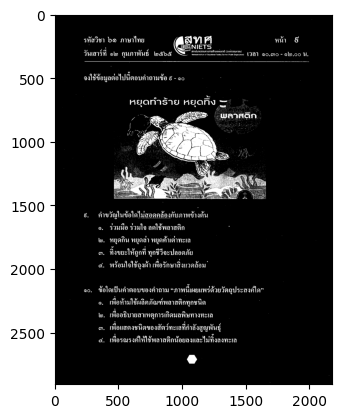

In [ ]:
def clearer(image):
    img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _ , thresh = cv2.threshold(img_gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    print(img_gray)
    plt.imshow(thresh, cmap='gray')
    return thresh

clearer_img = clearer(img)

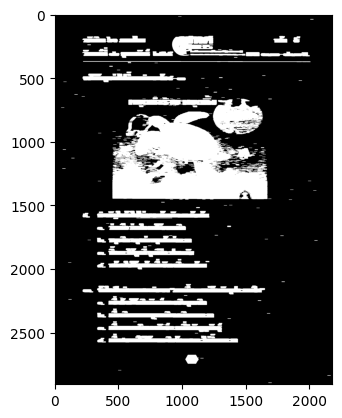

In [ ]:
kernel = np.ones((3,25), np.uint8)

#vertical lines เพื่อขยายขอบให้เป็นขอบที่ชัดเจนขึ้น ทำให้ง่ายต่อการตรวจสอบขอบ และการนับขอบ โดยใช้ kernel ขนาด 3x25 และใช้การทำซ้ำ 1 ครั้ง
dilation = cv2.dilate(clearer_img, kernel, iterations=1)
plt.imshow(dilation, cmap='gray')

In [ ]:
#หาเส้นขอบ โดยใช้ cv2.RETR_EXTERNAL คือการหาเส้นขอบที่เป็นเส้นขอบภายนอกที่สุด และ cv2.CHAIN_APPROX_NONE คือการหาเส้นขอบที่ไม่มีการประมาณ
contours, _ = cv2.findContours(dilation.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

#เรียงค่าตาม Y ตามลำดับน้อยไปมาก
sorted_lines = sorted(contours, key = lambda line : cv2.boundingRect(line)[1])

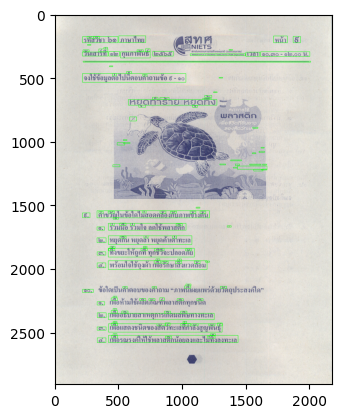

(37, 161, 3)


In [ ]:
cropped_images = []
picture = []
img_for_rec = img.copy()
median_height = np.median([cropped_region.shape[0] for cropped_region in sorted_lines])
for ctr in sorted_lines:
    x, y, w, h = cv2.boundingRect(ctr)
    #เอารูป Original มาตัด

    cropped_region = img[y:y+h, x:x+w] 

    if cropped_region.shape[0] > median_height:
        picture.append(cropped_region)
    else:
        cv2.rectangle(img_for_rec, (x,y), (x+w, y+h), (0,255,0), 2)
        cropped_images.append(cropped_region)

        

plt.imshow(img_for_rec) 
plt.show()
cv2.imshow(f'Cropped Image {1}', cv2.cvtColor(cropped_images[13], cv2.COLOR_BGR2GRAY))
print(cropped_images[13].shape)
cv2.waitKey(0)
cv2.destroyAllWindows()

[[205 206 211 ... 201 203 208]
 [207 208 214 ... 199 199 201]
 [209 211 214 ... 206 202 200]
 ...
 [212 213 214 ... 214 213 212]
 [215 215 215 ... 214 213 212]
 [213 212 213 ... 213 213 213]]
[[213 210 210 ... 213 215 219]
 [213 212 210 ... 210 212 218]
 [212 216 211 ... 211 210 215]
 ...
 [221 220 219 ... 215 213 211]
 [220 221 220 ... 216 213 211]
 [222 219 220 ... 214 205 206]]
[[216 211 206 ... 213 216 213]
 [211 207 207 ... 220 216 218]
 [213 210 210 ... 218 211 215]
 ...
 [215 215 216 ... 215 220 215]
 [219 218 220 ... 217 215 210]
 [218 217 219 ... 211 215 217]]
[[211 207 206 209 211 210 207 204 203 202 204 206 208 202 210 210 211 214
  208 199 199 192 189 189 193 196 198 204 212 211 209 207 206 206 206 206
  204 205 204 210 210 206 211 214 206 210 208 208]
 [212 210 206 208 214 203 213 206 200 208 207 205 217 209 215 208 201 200
  186 164 151 135 139 140 140 152 173 186 187 200 203 210 210 208 214 216
  203 202 200 209 214 205 202 209 212 215 213 212]
 [213 211 207 209 213 206 

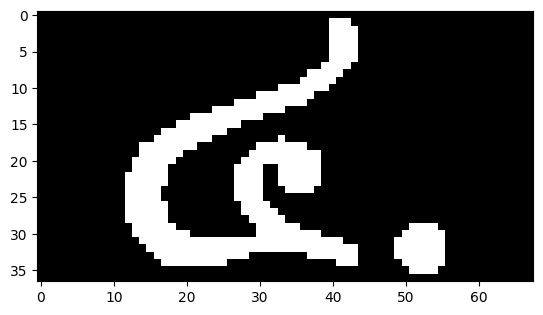

In [ ]:
cropped_thresh = []
for i in cropped_images:
    cropped_thresh.append(clearer(i))



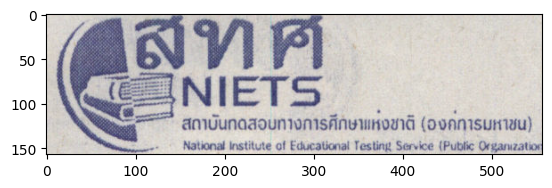

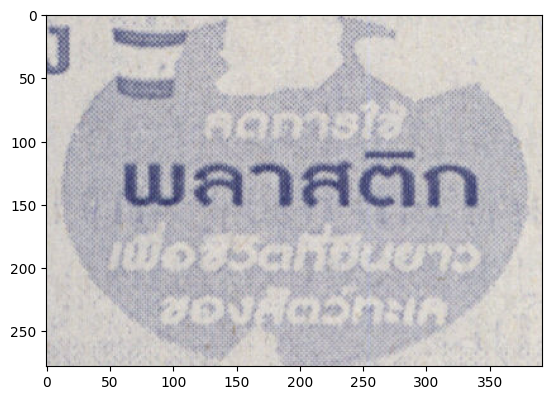

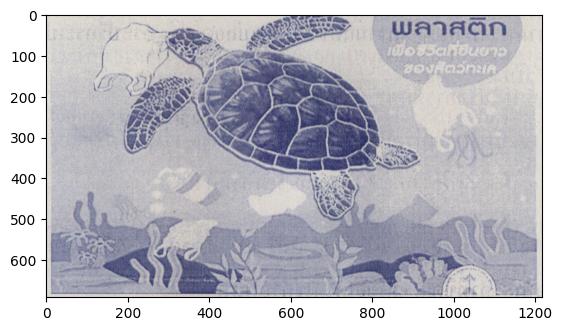

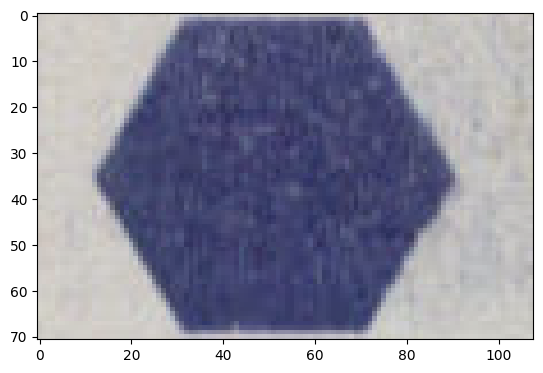

In [ ]:
for i in picture:
    plt.imshow(i)
    plt.show()

In [ ]:
def character_segmentation(img):
    """
    Segment characters in the given image.

    Parameters:
        img (ndarray): Binary image containing characters.

    Returns:
        segmented_characters (list): List of segmented characters.
    """
    labels, num_labels = label_connected_components(img)
    segmented_characters = []

    for i in range(1, num_labels + 1):
        indices = np.where(labels == i)
        min_row, min_col = np.min(indices, axis=1)
        max_row, max_col = np.max(indices, axis=1)
        
        character_segment = img[min_row:max_row+1, min_col:max_col+1]
        segmented_characters.append(character_segment)
    
    return segmented_characters


def label_connected_components(binary_image):
    """
    Label connected components in the binary image.

    Parameters:
        binary_image (ndarray): Binary image to label connected components.

    Returns:
        labels (ndarray): Matrix containing labels of each pixel.
        num_labels (int): Number of labels.
    """
    labels = np.zeros_like(binary_image)
    label_count = 1

    for i in range(binary_image.shape[0]):
        for j in range(binary_image.shape[1]):
            if binary_image[i, j] == 255 and labels[i, j] == 0:
                stack = [(i, j)]
                while stack:
                    row, col = stack.pop()
                    labels[row, col] = label_count
                    for dr in [-1, 0, 1]:
                        for dc in [-1, 0, 1]:
                            if dr == 0 and dc == 0:
                                continue
                            r = row + dr
                            c = col + dc
                            if 0 <= r < binary_image.shape[0] and 0 <= c < binary_image.shape[1] and \
                               binary_image[r, c] == 255 and labels[r, c] == 0:
                                stack.append((r, c))
                label_count += 1

    num_labels = label_count - 1
    return labels, num_labels


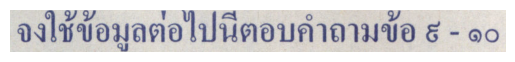

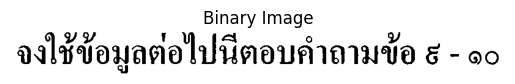

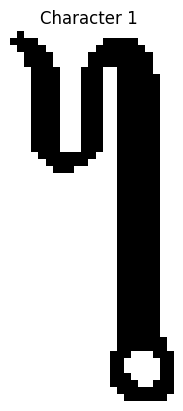

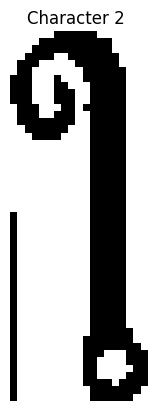

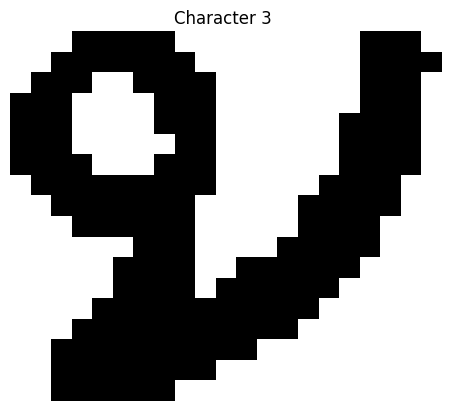

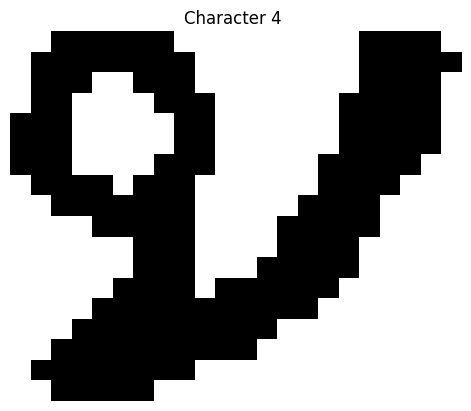

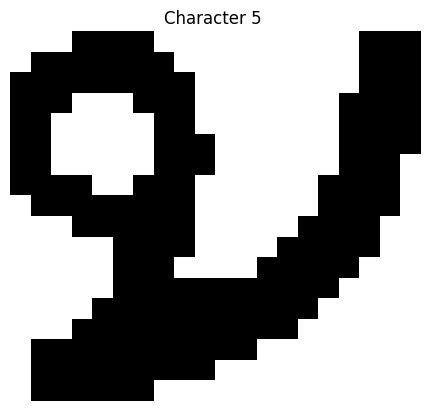

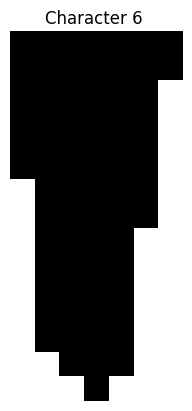

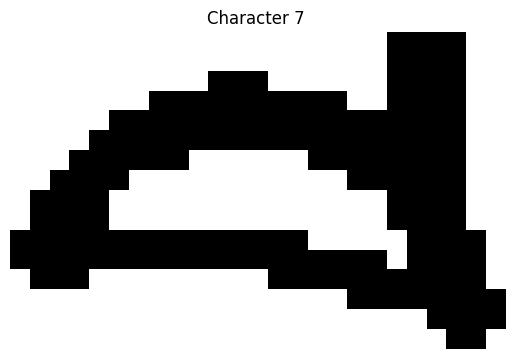

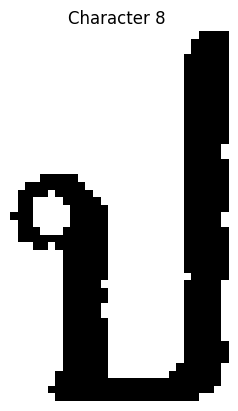

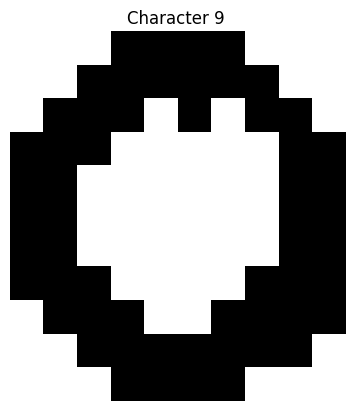

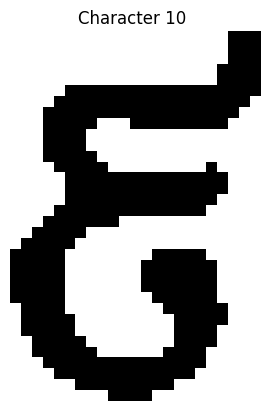

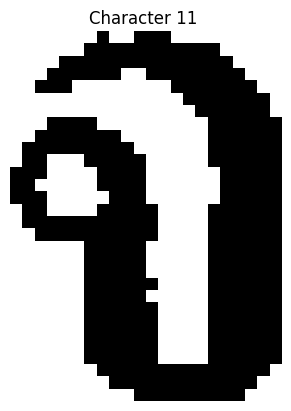

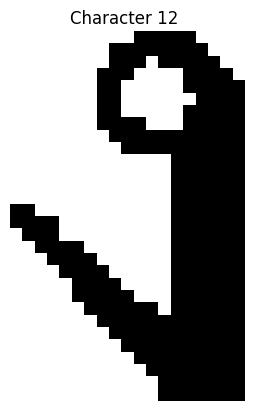

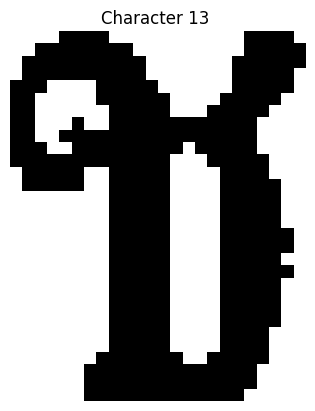

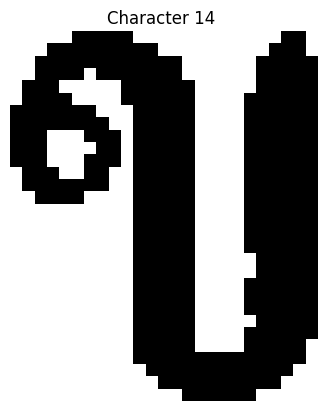

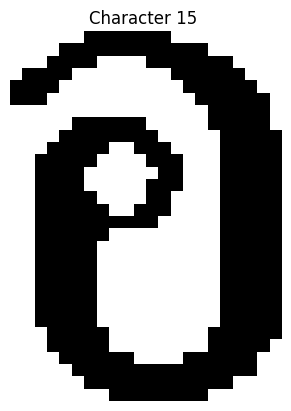

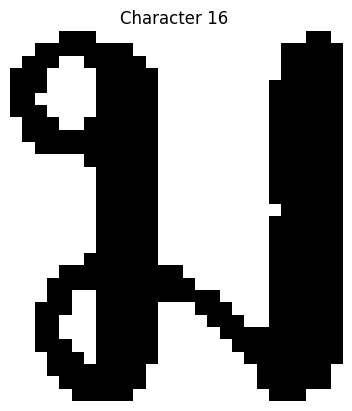

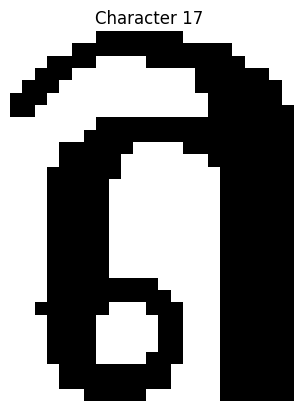

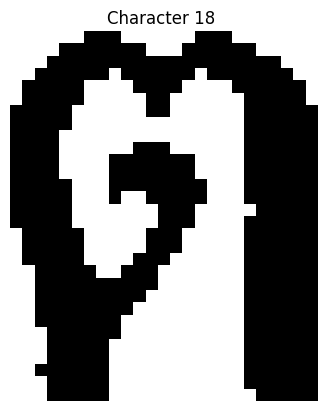

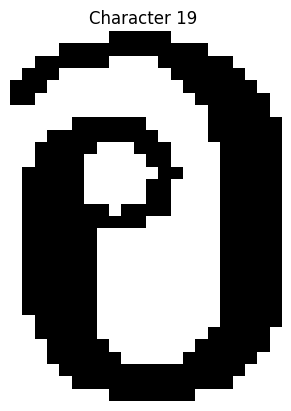

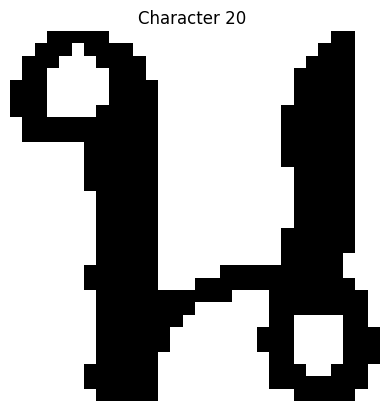

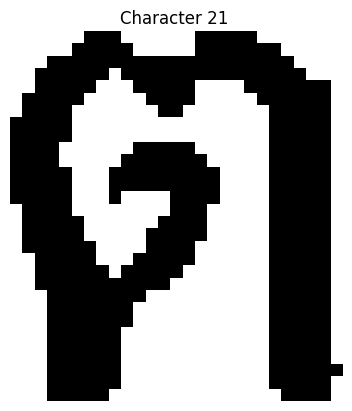

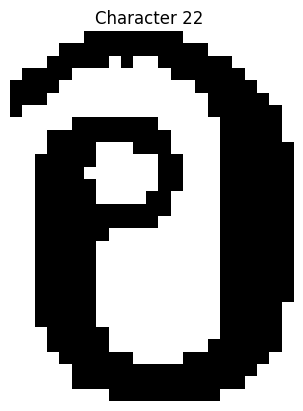

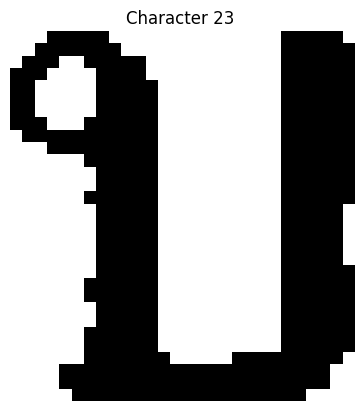

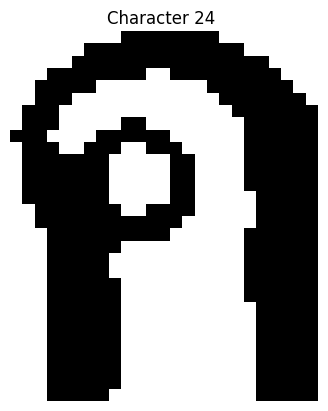

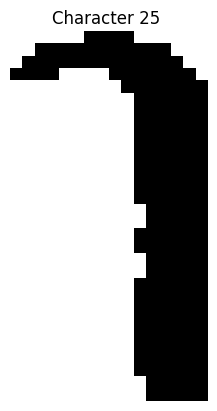

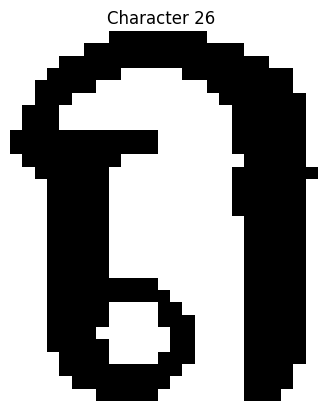

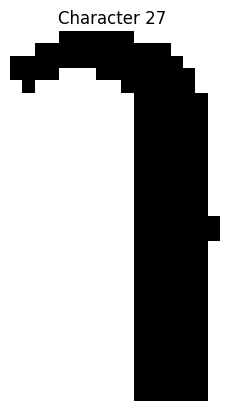

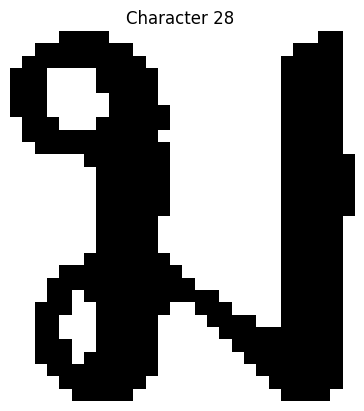

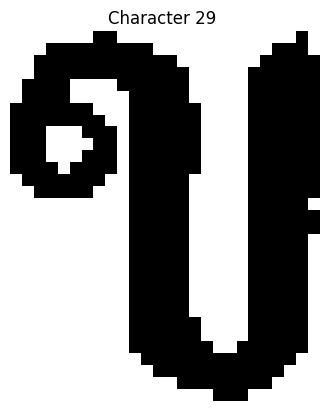

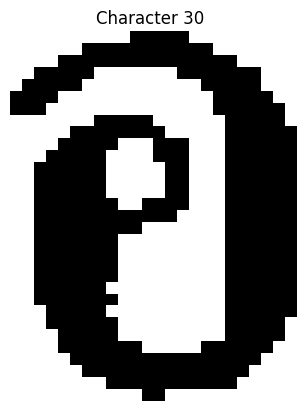

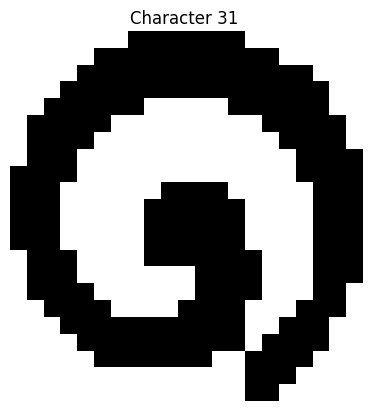

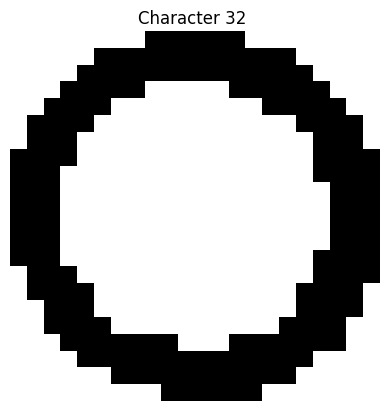

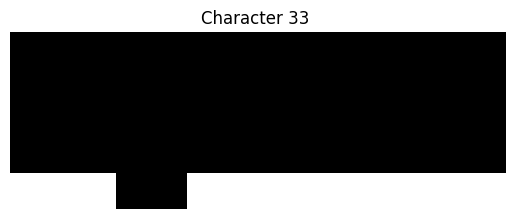

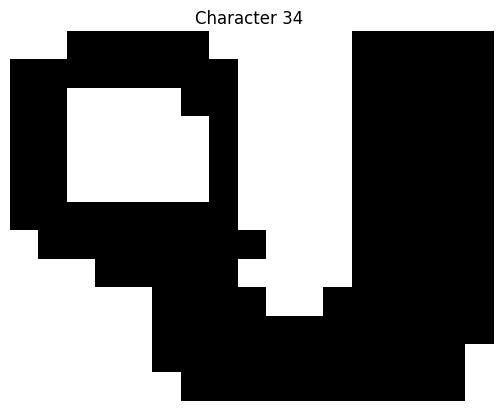

In [ ]:
store = []
segmented_character = character_segmentation(cropped_thresh[23])
plt.figure()
plt.imshow(cropped_images[23], cmap='gray')
plt.axis('off')
plt.show()

plt.figure()
plt.imshow(cv2.bitwise_not(cropped_thresh[23]), cmap='gray')
plt.title('Binary Image')
plt.axis('off')
plt.show()
for i, char_segment in enumerate(segmented_character):
    store.append(cv2.bitwise_not(char_segment))
    plt.figure()
    plt.imshow(cv2.bitwise_not(char_segment), cmap='gray')
    plt.title(f'Character {i + 1} ')
    plt.axis('off')
    plt.show()

In [ ]:

# segmented_vowel = vowel_segmentation(segmented_character[1])

# for i, char_segment in enumerate(segmented_vowel):
#     print(char_segment)
#     cv2.imshow(f'Character {i + 1}', char_segment)


# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [ ]:
# vowel_characters = []
# for char_segment in segmented_character:
#     vowel_characters.append(vowel_segmentation(char_segment))

# for i, vowel_segment_list in enumerate(vowel_characters):
#     for j, vowel_segment in enumerate(vowel_segment_list):
#         cv2.imshow(f'Vowel {i + 1} - Segment {j + 1}', vowel_segment)
#         cv2.waitKey(0)

# cv2.destroyAllWindows()


In [ ]:

# def vowel_segmentation(word_segment, character_threshold=3500, character_height=10, character_gap=5):
#     horizontal_projection = np.sum(word_segment, axis=1)
#     character_peaks, _ = find_peaks(horizontal_projection, height=character_threshold)

#     segmented_characters = []

#     for peak_row in character_peaks:
#         middle_row = peak_row
#         start_row = max(0, middle_row - character_height // 2 - character_gap)
#         end_row = min(word_segment.shape[0], middle_row + character_height // 2)
#         character_segment = word_segment[start_row:end_row, :]
#         segmented_characters.append(character_segment)

#     return segmented_characters


# def char_segmentation(image, character_threshold=3500, character_height=10, character_gap=5):
#     horizontal_projection = np.sum(image, axis=1)
#     character_peaks, _ = find_peaks(horizontal_projection, height=character_threshold)

#     segmented_characters = []

#     for i in range(len(character_peaks) - 1):
#         start_row = character_peaks[i]
#         end_row = character_peaks[i + 1]
#         character_segment = image[start_row:end_row, :]
#         segmented_characters.append(character_segment)
#     segmented_characters.append(image[character_peaks[-1]:, :])

#     return segmented_characters

In [ ]:
# vo = characters_list[3]
# segmented_characters = char_segmentation(characters_list[3])

# for i, char_segment in enumerate(segmented_characters):
#     print(char_segment)
#     cv2.imshow(f'Character {i + 1}', char_segment)


# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [ ]:
# segmented_vowel = vowel_segmentation(vo)

# for i, char_segment in enumerate(segmented_vowel):
#     cv2.imshow(f'Character {i + 1}', char_segment)


# cv2.waitKey(0)
# cv2.destroyAllWindows()